# Install and Import


In [1]:
!pip -q install summa
!pip -q install beautifulsoup4

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.9/54.9 kB 3.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done


In [2]:
from importlib.metadata import version
import nltk
from nltk.corpus import stopwords
import tensorflow
import summa
import pandas as pd
import numpy as np
import re
from bs4 import BeautifulSoup

# 불용어 다운로드
nltk.download('stopwords')

# Warnings 없애기
import warnings
warnings.filterwarnings(action='ignore')

print(nltk.__version__)
print(tensorflow.__version__)
print(pd.__version__)
print(version('summa'))

3.9.1
2.18.0
2.2.2
1.2.0


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [6]:
import urllib.request
urllib.request.urlretrieve("https://raw.githubusercontent.com/sunnysai12345/News_Summary/master/news_summary_more.csv", filename="news_summary_more.csv")
data = pd.read_csv('news_summary_more.csv', encoding='iso-8859-1')
data.sample(10)

,headlines,text
94683,India's oldest pending civil case in Rajasthan...,India's oldest pending civil case has been in ...
16694,Patralekhaa denies reports of Rajkummar asking...,Denying reports that her boyfriend Rajkummar R...
22086,Single parenting can be dangerous for society:...,"During a recent court hearing, Madras High Cou..."
15627,OnePlus 6T to have 3700mAh battery instead of ...,OnePlus might be upgrading the battery capacit...
35328,NIA to examine court's verdict in Mecca Masjid...,The National Investigation Agency (NIA) on Mon...
39241,India's richest man's pay is less than that of...,India's richest man Mukesh Ambani's annual sal...
66835,BMC demolishes illegal canteen in SRK's Red Ch...,Mumbai's Brihanmumbai Municipal Corporation (B...
19401,"Ã¢ÂÂ¹1,000 crore received till date as donati...",The Kerala Chief Minister's Distress Relief Fu...
60866,Deepika slams ban on Mahira Khan's film on rap...,Deepika Padukone has slammed the ban on Pakist...
88073,Indian-origin minister may become first openly...,Indian-origin Irish Welfare Minister Leo Varad...


# 데이터 전처리

## Clean

null sample확인

In [7]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 98401 entries, 0 to 98400
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   headlines  98401 non-null  object
 1   text       98401 non-null  object
dtypes: object(2)
memory usage: 1.5+ MB


null 값 없음

중복데이터 확인

In [8]:
print('헤드라인 중복 개수: ', len(data) - data['headlines'].nunique())
print('헤드라인 중복 제거 후 개수: ',data['headlines'].nunique())
print('텍스트 중복 개수: ', len(data) - data['text'].nunique())
print('텍스트 중복 제거 후 개수: ',data['text'].nunique())

헤드라인 중복 개수:  121
헤드라인 중복 제거 후 개수:  98280
텍스트 중복 개수:  41
텍스트 중복 제거 후 개수:  98360


텍스트 기준 중복 제거

In [9]:
data.drop_duplicates(subset = ['text'], inplace=True)
print('전체 샘플수 :', (len(data)))

전체 샘플수 : 98360


정규화 사전

https://stackoverflow.com/questions/19790188/expanding-english-language-contractions-in-python

In [10]:
contractions = {"ain't": "is not", "aren't": "are not","can't": "cannot", "'cause": "because", "could've": "could have", "couldn't": "could not",
                           "didn't": "did not",  "doesn't": "does not", "don't": "do not", "hadn't": "had not", "hasn't": "has not", "haven't": "have not",
                           "he'd": "he would","he'll": "he will", "he's": "he is", "how'd": "how did", "how'd'y": "how do you", "how'll": "how will", "how's": "how is",
                           "I'd": "I would", "I'd've": "I would have", "I'll": "I will", "I'll've": "I will have","I'm": "I am", "I've": "I have", "i'd": "i would",
                           "i'd've": "i would have", "i'll": "i will",  "i'll've": "i will have","i'm": "i am", "i've": "i have", "isn't": "is not", "it'd": "it would",
                           "it'd've": "it would have", "it'll": "it will", "it'll've": "it will have","it's": "it is", "let's": "let us", "ma'am": "madam",
                           "mayn't": "may not", "might've": "might have","mightn't": "might not","mightn't've": "might not have", "must've": "must have",
                           "mustn't": "must not", "mustn't've": "must not have", "needn't": "need not", "needn't've": "need not have","o'clock": "of the clock",
                           "oughtn't": "ought not", "oughtn't've": "ought not have", "shan't": "shall not", "sha'n't": "shall not", "shan't've": "shall not have",
                           "she'd": "she would", "she'd've": "she would have", "she'll": "she will", "she'll've": "she will have", "she's": "she is",
                           "should've": "should have", "shouldn't": "should not", "shouldn't've": "should not have", "so've": "so have","so's": "so as",
                           "this's": "this is","that'd": "that would", "that'd've": "that would have", "that's": "that is", "there'd": "there would",
                           "there'd've": "there would have", "there's": "there is", "here's": "here is","they'd": "they would", "they'd've": "they would have",
                           "they'll": "they will", "they'll've": "they will have", "they're": "they are", "they've": "they have", "to've": "to have",
                           "wasn't": "was not", "we'd": "we would", "we'd've": "we would have", "we'll": "we will", "we'll've": "we will have", "we're": "we are",
                           "we've": "we have", "weren't": "were not", "what'll": "what will", "what'll've": "what will have", "what're": "what are",
                           "what's": "what is", "what've": "what have", "when's": "when is", "when've": "when have", "where'd": "where did", "where's": "where is",
                           "where've": "where have", "who'll": "who will", "who'll've": "who will have", "who's": "who is", "who've": "who have",
                           "why's": "why is", "why've": "why have", "will've": "will have", "won't": "will not", "won't've": "will not have",
                           "would've": "would have", "wouldn't": "would not", "wouldn't've": "would not have", "y'all": "you all",
                           "y'all'd": "you all would","y'all'd've": "you all would have","y'all're": "you all are","y'all've": "you all have",
                           "you'd": "you would", "you'd've": "you would have", "you'll": "you will", "you'll've": "you will have",
                           "you're": "you are", "you've": "you have"}

print("정규화 사전의 수: ", len(contractions))

정규화 사전의 수:  120


불용어 확인

In [11]:
print('불용어 개수 :', len(stopwords.words('english') ))
print(stopwords.words('english'))

불용어 개수 : 198
['a', 'about', 'above', 'after', 'again', 'against', 'ain', 'all', 'am', 'an', 'and', 'any', 'are', 'aren', "aren't", 'as', 'at', 'be', 'because', 'been', 'before', 'being', 'below', 'between', 'both', 'but', 'by', 'can', 'couldn', "couldn't", 'd', 'did', 'didn', "didn't", 'do', 'does', 'doesn', "doesn't", 'doing', 'don', "don't", 'down', 'during', 'each', 'few', 'for', 'from', 'further', 'had', 'hadn', "hadn't", 'has', 'hasn', "hasn't", 'have', 'haven', "haven't", 'having', 'he', "he'd", "he'll", 'her', 'here', 'hers', 'herself', "he's", 'him', 'himself', 'his', 'how', 'i', "i'd", 'if', "i'll", "i'm", 'in', 'into', 'is', 'isn', "isn't", 'it', "it'd", "it'll", "it's", 'its', 'itself', "i've", 'just', 'll', 'm', 'ma', 'me', 'mightn', "mightn't", 'more', 'most', 'mustn', "mustn't", 'my', 'myself', 'needn', "needn't", 'no', 'nor', 'not', 'now', 'o', 'of', 'off', 'on', 'once', 'only', 'or', 'other', 'our', 'ours', 'ourselves', 'out', 'over', 'own', 're', 's', 'same', 'shan', "

전처리 실행

In [12]:
def preprocess_sentence(sentence, remove_stopwords=True):
    sentence = sentence.lower() # 텍스트 소문자화
    sentence = BeautifulSoup(sentence, "lxml").text # html 태그 제거
    sentence = re.sub(r'\([^)]*\)', '', sentence) # 괄호로 닫힌 문자열 (...) 제거
    sentence = re.sub('"','', sentence) # 쌍따옴표 " 제거
    sentence = re.sub('\'','', sentence) # 따옴표 " 제거

    sentence = ' '.join([contractions[t] if t in contractions else t for t in sentence.split(" ")]) # 약어 정규화
    sentence = re.sub(r"'s\b","", sentence) # 소유격 제거.
    sentence = re.sub("[^a-zA-Z]", " ", sentence) # 영어 외 문자(숫자, 특수문자 등) 공백으로 변환 - 숫자도?
    sentence = re.sub('[m]{2,}', 'mm', sentence) # m이 3개 이상이면 2개로 변경. Ex) ummmmmmm yeah -> umm yeah

    # 불용어 제거 (Text)
    if remove_stopwords:
        tokens = ' '.join(word for word in sentence.split() if not word in stopwords.words('english') if len(word) > 1)
    # 불용어 미제거 (headlines)
    else:
        tokens = ' '.join(word for word in sentence.split() if len(word) > 1)
    return tokens

In [13]:
# text 전처리 (불용어 제거 O)
data["clean_text"] = data["text"].apply(lambda x: preprocess_sentence(x))

# headline 전처리 (불용어 제거 X)
data["clean_headlines"] = data["headlines"].apply(lambda x: preprocess_sentence(x, remove_stopwords=False))

data.head()

,headlines,text,clean_text,clean_headlines
0,upGrad learner switches to career in ML & Al w...,"Saurav Kant, an alumnus of upGrad and IIIT-B's...",saurav kant alumnus upgrad iiit bs pg program ...,upgrad learner switches to career in ml al wit...
1,Delhi techie wins free food from Swiggy for on...,Kunal Shah's credit card bill payment platform...,kunal shahs credit card bill payment platform ...,delhi techie wins free food from swiggy for on...
2,New Zealand end Rohit Sharma-led India's 12-ma...,New Zealand defeated India by 8 wickets in the...,new zealand defeated india wickets fourth odi ...,new zealand end rohit sharma led indias match ...
3,Aegon life iTerm insurance plan helps customer...,"With Aegon Life iTerm Insurance plan, customer...",aegon life iterm insurance plan customers enjo...,aegon life iterm insurance plan helps customer...
4,"Have known Hirani for yrs, what if MeToo claim...",Speaking about the sexual harassment allegatio...,speaking sexual harassment allegations rajkuma...,have known hirani for yrs what if metoo claims...


전처리 후 생긴 null 값 제거

In [14]:
data.replace('', np.nan, inplace=True)
data.dropna(axis=0, inplace=True)
print('전체 샘플수 :', (len(data)))

전체 샘플수 : 98360


⚠️ 로컬 저장하여 전처리 중복실행 방지(시간 오래걸림!)

In [15]:
data.to_csv('/content/drive/MyDrive/Colab Notebooks/AIFFEL/QuestC/data/clean_data.csv', index=False)

In [3]:
data = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/AIFFEL/QuestC/data/clean_data.csv')
data.head()

,headlines,text,clean_text,clean_headlines
0,upGrad learner switches to career in ML & Al w...,"Saurav Kant, an alumnus of upGrad and IIIT-B's...",saurav kant alumnus upgrad iiit bs pg program ...,upgrad learner switches to career in ml al wit...
1,Delhi techie wins free food from Swiggy for on...,Kunal Shah's credit card bill payment platform...,kunal shahs credit card bill payment platform ...,delhi techie wins free food from swiggy for on...
2,New Zealand end Rohit Sharma-led India's 12-ma...,New Zealand defeated India by 8 wickets in the...,new zealand defeated india wickets fourth odi ...,new zealand end rohit sharma led indias match ...
3,Aegon life iTerm insurance plan helps customer...,"With Aegon Life iTerm Insurance plan, customer...",aegon life iterm insurance plan customers enjo...,aegon life iterm insurance plan helps customer...
4,"Have known Hirani for yrs, what if MeToo claim...",Speaking about the sexual harassment allegatio...,speaking sexual harassment allegations rajkuma...,have known hirani for yrs what if metoo claims...


# Train, Test Split

샘플 최대 길이 정하기

In [4]:
def text_head_plot(data):
    import matplotlib.pyplot as plt
    import seaborn as sns

    text_len = [len(i.split()) for i in data['clean_text']]
    headline_len = [len(i.split()) for i in data['clean_headlines']]

    print(f"text 최소, 최대, 평균길이\n{np.min(text_len)}, {np.max(text_len)}, {np.mean(text_len)}")
    print(f"headline 최소, 최대, 평균길이\n{np.min(headline_len)}, {np.max(headline_len)}, {np.mean(headline_len)}")

    fig, axes = plt.subplots(1, 2, figsize=(10, 5))
    sns.histplot(text_len, ax=axes[0])
    sns.histplot(headline_len, ax=axes[1])
    axes[0].set_title("Text")
    axes[1].set_title("Headline")
    plt.tight_layout()
    plt.show()

    fig, axes = plt.subplots(1, 2, figsize=(10, 5))
    sns.boxplot(text_len, ax=axes[0])
    sns.boxplot(headline_len, ax=axes[1])
    axes[0].set_title("Text")
    axes[1].set_title("Headline")
    plt.tight_layout()
    plt.show()

def high_below_threshold_len(min_len,max_len, nested_list):
  cnt = 0
  for s in nested_list:
    if(min_len<=len(s.split()) <= max_len):
        cnt = cnt + 1
  print('전체 샘플 중 길이가 %s 이상 %s 이하인 샘플의 비율: %s'%(min_len,max_len, (cnt / len(nested_list))))


text 최소, 최대, 평균길이
1, 60, 35.25167751118341
headline 최소, 최대, 평균길이
1, 15, 9.265982106547376


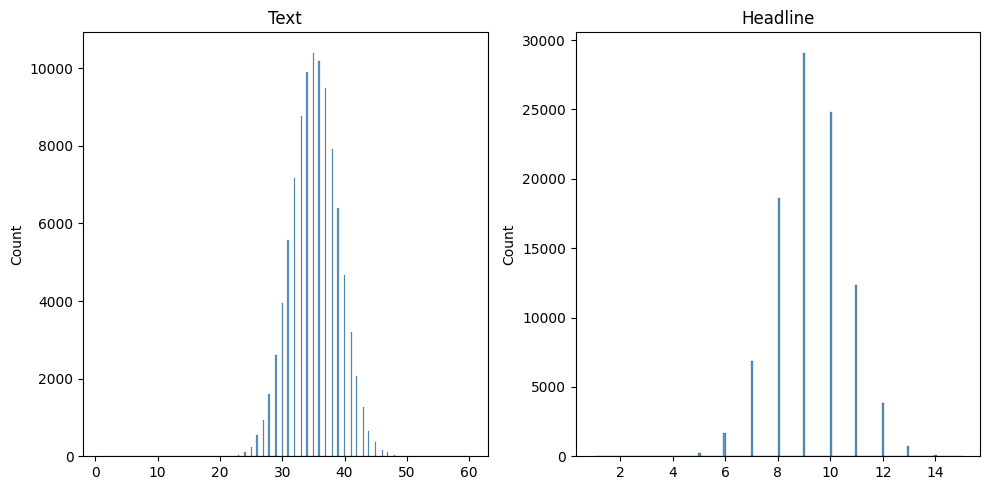

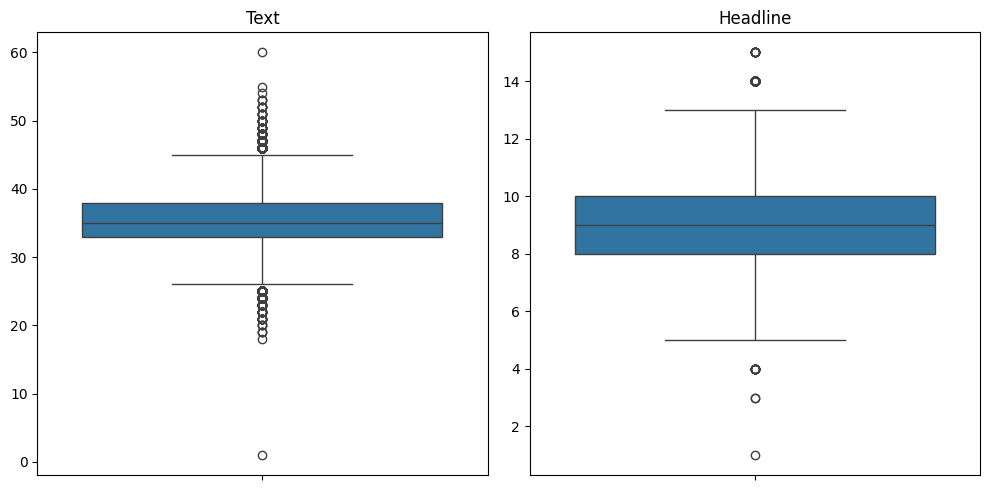

In [5]:
text_head_plot(data)

정규분포형태이므로 최소, 최대 설정한다

In [6]:
text_min_len = 10
text_max_len = 50
head_min_len = 5
head_max_len = 13

high_below_threshold_len(text_min_len,text_max_len, data['clean_text'])
high_below_threshold_len(head_min_len,head_max_len,  data['clean_headlines'])

전체 샘플 중 길이가 10 이상 50 이하인 샘플의 비율: 0.9998169987799919
전체 샘플 중 길이가 5 이상 13 이하인 샘플의 비율: 0.9987698251321675


In [7]:
sampled_data = data[
    (data['clean_text'].apply(lambda x: text_min_len <= len(x.split()) <= text_max_len)) &
    (data['clean_headlines'].apply(lambda x: head_min_len <= len(x.split()) <= head_max_len))
]
sampled_data.head()

,headlines,text,clean_text,clean_headlines
0,upGrad learner switches to career in ML & Al w...,"Saurav Kant, an alumnus of upGrad and IIIT-B's...",saurav kant alumnus upgrad iiit bs pg program ...,upgrad learner switches to career in ml al wit...
1,Delhi techie wins free food from Swiggy for on...,Kunal Shah's credit card bill payment platform...,kunal shahs credit card bill payment platform ...,delhi techie wins free food from swiggy for on...
2,New Zealand end Rohit Sharma-led India's 12-ma...,New Zealand defeated India by 8 wickets in the...,new zealand defeated india wickets fourth odi ...,new zealand end rohit sharma led indias match ...
3,Aegon life iTerm insurance plan helps customer...,"With Aegon Life iTerm Insurance plan, customer...",aegon life iterm insurance plan customers enjo...,aegon life iterm insurance plan helps customer...
4,"Have known Hirani for yrs, what if MeToo claim...",Speaking about the sexual harassment allegatio...,speaking sexual harassment allegations rajkuma...,have known hirani for yrs what if metoo claims...


headlines에 시작, 종료 토큰을 추가한다.

In [8]:
sampled_data['decoder_input'] = sampled_data['clean_headlines'].apply(lambda x : 'sostoken '+ x)
sampled_data['decoder_target'] = sampled_data['clean_headlines'].apply(lambda x : x + ' eostoken')

# 결과 확인
sampled_data[['clean_headlines', 'decoder_input', 'decoder_target']].head()

,clean_headlines,decoder_input,decoder_target
0,upgrad learner switches to career in ml al wit...,sostoken upgrad learner switches to career in ...,upgrad learner switches to career in ml al wit...
1,delhi techie wins free food from swiggy for on...,sostoken delhi techie wins free food from swig...,delhi techie wins free food from swiggy for on...
2,new zealand end rohit sharma led indias match ...,sostoken new zealand end rohit sharma led indi...,new zealand end rohit sharma led indias match ...
3,aegon life iterm insurance plan helps customer...,sostoken aegon life iterm insurance plan helps...,aegon life iterm insurance plan helps customer...
4,have known hirani for yrs what if metoo claims...,sostoken have known hirani for yrs what if met...,have known hirani for yrs what if metoo claims...


디코더 부분 input, terget data 처리 완료

인코더용 입력, 디코더용 입력, 디코더용 레이블 재저장

In [32]:
encoder_input = np.array(sampled_data['clean_text']) # 인코더의 입력
decoder_input = np.array(sampled_data['decoder_input']) # 디코더의 입력
decoder_target = np.array(sampled_data['decoder_target']) # 디코더의 레이블

print(encoder_input.shape,decoder_input.shape,decoder_target.shape)
print(encoder_input[:3])
print(decoder_input[:3])
print(decoder_target[:3])

(98222,) (98222,) (98222,)
['saurav kant alumnus upgrad iiit bs pg program machine learning artificial intelligence sr systems engineer infosys almost years work experience program upgrads degree career support helped transition data scientist tech mahindra salary hike upgrads online power learning powered lakh careers'
 'kunal shahs credit card bill payment platform cred gave users chance win free food swiggy one year pranav kaushik delhi techie bagged reward spending cred coins users get one cred coin per rupee bill paid used avail rewards brands like ixigo bookmyshow ubereats cult fit'
 'new zealand defeated india wickets fourth odi hamilton thursday win first match five match odi series india lost international match rohit sharmas captaincy consecutive victories dating back march match witnessed india getting seventh lowest total odi cricket history']
['sostoken upgrad learner switches to career in ml al with salary hike'
 'sostoken delhi techie wins free food from swiggy for one y

훈련, 테스트 split을 위해서 indices를 섞어준다

In [33]:
# indices를 이용해 데이터를 섞고 split한다,
indices = np.arange(encoder_input.shape[0])
np.random.shuffle(indices)
print(indices)

[23846 25553 75248 ... 21828 24146 95625]


test 시의 data leakeage를 피하기 위해 validation set만든다.

In [34]:
# 데이터 섞는다
encoder_input = encoder_input[indices]
decoder_input = decoder_input[indices]
decoder_target = decoder_target[indices]

# 훈련 데이터 0.7
n_of_val = int(len(encoder_input)*0.2)
n_total = len(encoder_input)
n_test = int(n_total * 0.15)
n_val = int(n_total * 0.15)
print('Test, Val 데이터의 수 :', n_of_val)

# split
encoder_input_train = encoder_input[:-(n_test + n_val)]
decoder_input_train = decoder_input[:-(n_test + n_val)]
decoder_target_train = decoder_target[:-(n_test + n_val)]

encoder_input_val = encoder_input[-(n_test + n_val):-n_test]
decoder_input_val = decoder_input[-(n_test + n_val):-n_test]
decoder_target_val = decoder_target[-(n_test + n_val):-n_test]

encoder_input_test = encoder_input[-n_test:]
decoder_input_test = decoder_input[-n_test:]
decoder_target_test = decoder_target[-n_test:]

print('훈련 데이터의 개수 :', len(encoder_input_train))
print('훈련 레이블의 개수 :', len(decoder_input_train))
print('Valid 데이터의 개수 :', len(encoder_input_val))
print('Valid 레이블의 개수 :', len(decoder_input_val))
print('테스트 데이터의 개수 :', len(encoder_input_test))
print('테스트 레이블의 개수 :', len(decoder_input_test))

Test, Val 데이터의 수 : 19644
훈련 데이터의 개수 : 68756
훈련 레이블의 개수 : 68756
Valid 데이터의 개수 : 14733
Valid 레이블의 개수 : 14733
테스트 데이터의 개수 : 14733
테스트 레이블의 개수 : 14733


# Encoding

인코더의 토크나이저

In [35]:
from tensorflow.keras.preprocessing.text import Tokenizer
src_tokenizer = Tokenizer() # 토크나이저 정의
src_tokenizer.fit_on_texts(encoder_input_train) # 입력된 데이터로부터 단어 집합 생성

In [36]:
threshold = 7
total_cnt = len(src_tokenizer.word_index) # 단어의 수
rare_cnt = 0 # 등장 빈도수가 threshold보다 작은 단어의 개수를 카운트
total_freq = 0 # 훈련 데이터의 전체 단어 빈도수 총 합
rare_freq = 0 # 등장 빈도수가 threshold보다 작은 단어의 등장 빈도수의 총 합

# 단어와 빈도수의 쌍(pair)을 key와 value로 받는다.
for key, value in src_tokenizer.word_counts.items():
    total_freq = total_freq + value

    # 단어의 등장 빈도수가 threshold보다 작으면
    if(value < threshold):
        rare_cnt = rare_cnt + 1
        rare_freq = rare_freq + value

print('단어 집합(vocabulary)의 크기 :', total_cnt)
print('등장 빈도가 %s번 이하인 희귀 단어의 수: %s'%(threshold - 1, rare_cnt))
print('단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 %s'%(total_cnt - rare_cnt))
print("단어 집합에서 희귀 단어의 비율:", (rare_cnt / total_cnt)*100)
print("전체 등장 빈도에서 희귀 단어 등장 빈도 비율:", (rare_freq / total_freq)*100)

단어 집합(vocabulary)의 크기 : 69622
등장 빈도가 6번 이하인 희귀 단어의 수: 48310
단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 21312
단어 집합에서 희귀 단어의 비율: 69.38898623998162
전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 4.018548033645962


In [39]:
src_vocab = 20000
src_tokenizer = Tokenizer(num_words=src_vocab) # 단어 집합의 크기를 제한
src_tokenizer.fit_on_texts(encoder_input_train) # 단어 집합 재생성

In [40]:
# 텍스트 시퀀스를 정수 시퀀스로 변환
encoder_input_train = src_tokenizer.texts_to_sequences(encoder_input_train)
encoder_input_val = src_tokenizer.texts_to_sequences(encoder_input_val)
encoder_input_test = src_tokenizer.texts_to_sequences(encoder_input_test)

# 잘 진행되었는지 샘플 출력
print(encoder_input_train[:3])

[[5, 435, 414, 1502, 5322, 1, 52, 69, 5782, 793, 2163, 527, 3705, 693, 3, 5, 458, 527, 2884, 1684, 1522, 1374, 2249, 1860, 5, 693, 11895, 5, 4563, 693, 418, 208], [517, 439, 9881, 1040, 9070, 501, 876, 1442, 16696, 614, 6233, 198, 122, 156, 1705, 180, 60, 144, 391, 66, 517, 4140, 501, 13094, 876, 16696, 8, 80, 342, 517, 964, 456], [10, 20, 552, 1069, 400, 629, 406, 181, 965, 19910, 23, 281, 181, 110, 461, 332, 629, 406, 414, 250, 1, 5259, 937, 1105, 4564, 1159, 3018, 1169, 292, 129, 178, 110, 45, 113, 58, 8021, 13560, 1169, 3497, 573, 2817]]


디코더의 토크나이저

In [41]:
tar_tokenizer = Tokenizer()
tar_tokenizer.fit_on_texts(decoder_input_train)

In [42]:
threshold = 6
total_cnt = len(tar_tokenizer.word_index) # 단어의 수
rare_cnt = 0 # 등장 빈도수가 threshold보다 작은 단어의 개수를 카운트
total_freq = 0 # 훈련 데이터의 전체 단어 빈도수 총 합
rare_freq = 0 # 등장 빈도수가 threshold보다 작은 단어의 등장 빈도수의 총 합

# 단어와 빈도수의 쌍(pair)을 key와 value로 받는다.
for key, value in tar_tokenizer.word_counts.items():
    total_freq = total_freq + value

    # 단어의 등장 빈도수가 threshold보다 작으면
    if(value < threshold):
        rare_cnt = rare_cnt + 1
        rare_freq = rare_freq + value

print('단어 집합(vocabulary)의 크기 :', total_cnt)
print('등장 빈도가 %s번 이하인 희귀 단어의 수: %s'%(threshold - 1, rare_cnt))
print('단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 %s'%(total_cnt - rare_cnt))
print("단어 집합에서 희귀 단어의 비율:", (rare_cnt / total_cnt)*100)
print("전체 등장 빈도에서 희귀 단어 등장 빈도 비율:", (rare_freq / total_freq)*100)

단어 집합(vocabulary)의 크기 : 30308
등장 빈도가 5번 이하인 희귀 단어의 수: 20358
단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 9950
단어 집합에서 희귀 단어의 비율: 67.17038405701466
전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 5.494206480578671


In [43]:
tar_vocab = 10000
tar_tokenizer = Tokenizer(num_words=tar_vocab)
tar_tokenizer.fit_on_texts(decoder_input_train)
tar_tokenizer.fit_on_texts(decoder_target_train)

# 텍스트 시퀀스를 정수 시퀀스로 변환
#train
decoder_input_train = tar_tokenizer.texts_to_sequences(decoder_input_train)
decoder_target_train = tar_tokenizer.texts_to_sequences(decoder_target_train)
#test
decoder_input_test = tar_tokenizer.texts_to_sequences(decoder_input_test)
decoder_target_test = tar_tokenizer.texts_to_sequences(decoder_target_test)
#validation
decoder_input_val = tar_tokenizer.texts_to_sequences(decoder_input_val)
decoder_target_val = tar_tokenizer.texts_to_sequences(decoder_target_val)

# 잘 변환되었는지 확인
print('input')
print('input ',decoder_input_train[:5])
print('target')
print('decoder ',decoder_target_train[:5])
print('val')
print('decoder ',decoder_target_val[:5])

input
input  [[1, 19, 9952, 2116, 6, 17, 2687, 4659, 12], [1, 4843, 9953, 24, 451, 4, 58, 3, 263, 4030, 7, 3283], [1, 23, 1252, 3, 734, 1224, 735, 231, 1379, 32], [1, 2947, 336, 56, 6, 3675], [1, 3189, 39, 1566, 142, 16, 3891, 1512, 3, 4031, 5, 1211]]
target
decoder  [[19, 9952, 2116, 6, 17, 2687, 4659, 12, 2], [4843, 9953, 24, 451, 4, 58, 3, 263, 4030, 7, 3283, 2], [23, 1252, 3, 734, 1224, 735, 231, 1379, 32, 2], [2947, 336, 56, 6, 3675, 2], [3189, 39, 1566, 142, 16, 3891, 1512, 3, 4031, 5, 1211, 2]]
val
decoder  [[5945, 4639, 7579, 24, 3366, 321, 10, 4476, 83, 816, 2], [8734, 896, 800, 4960, 4, 41, 1136, 1304, 1272, 2], [839, 1772, 12, 219, 882, 10, 196, 507, 6, 443, 2], [227, 910, 4016, 365, 557, 507, 6, 115, 446, 2], [21, 9330, 421, 788, 816, 7, 490, 6, 8839, 4, 386, 2]]


희귀단어에 의한 null데이터 삭제

In [44]:
drop_train = [index for index, sentence in enumerate(decoder_input_train) if len(sentence) == 1]
drop_test = [index for index, sentence in enumerate(decoder_input_test) if len(sentence) == 1]
drop_val = [index for index, sentence in enumerate(decoder_input_val) if len(sentence) == 1]

print('삭제할 훈련 데이터의 개수 :', len(drop_train))
print('삭제할 Validation 데이터의 개수 :', len(drop_val))
print('삭제할 테스트 데이터의 개수 :', len(drop_test))

encoder_input_train = [sentence for index, sentence in enumerate(encoder_input_train) if index not in drop_train]
decoder_input_train = [sentence for index, sentence in enumerate(decoder_input_train) if index not in drop_train]
decoder_target_train = [sentence for index, sentence in enumerate(decoder_target_train) if index not in drop_train]

encoder_input_val = [sentence for index, sentence in enumerate(encoder_input_val) if index not in drop_val]
decoder_input_val = [sentence for index, sentence in enumerate(decoder_input_val) if index not in drop_val]
decoder_target_val = [sentence for index, sentence in enumerate(decoder_target_val) if index not in drop_val]

encoder_input_test = [sentence for index, sentence in enumerate(encoder_input_test) if index not in drop_test]
decoder_input_test = [sentence for index, sentence in enumerate(decoder_input_test) if index not in drop_test]
decoder_target_test = [sentence for index, sentence in enumerate(decoder_target_test) if index not in drop_test]

print('훈련 데이터의 개수 :', len(encoder_input_train))
print('훈련 레이블의 개수 :', len(decoder_input_train))
print('테스트 데이터의 개수 :', len(encoder_input_test))
print('테스트 레이블의 개수 :', len(decoder_input_test))
print('Validation 데이터의 개수 :', len(encoder_input_val))
print('Validation 레이블의 개수 :', len(decoder_input_val))


삭제할 훈련 데이터의 개수 : 0
삭제할 Validation 데이터의 개수 : 0
삭제할 테스트 데이터의 개수 : 0
훈련 데이터의 개수 : 68756
훈련 레이블의 개수 : 68756
테스트 데이터의 개수 : 14733
테스트 레이블의 개수 : 14733
Validation 데이터의 개수 : 14733
Validation 레이블의 개수 : 14733


post padding 진행

In [45]:
from tensorflow.keras.preprocessing.sequence import pad_sequences

encoder_input_train = pad_sequences(encoder_input_train, maxlen=text_max_len, padding='post')
encoder_input_val = pad_sequences(encoder_input_val, maxlen=text_max_len, padding='post')
encoder_input_test = pad_sequences(encoder_input_test, maxlen=text_max_len, padding='post')

decoder_input_train = pad_sequences(decoder_input_train, maxlen=head_max_len, padding='post')
decoder_input_val= pad_sequences(decoder_input_val, maxlen=head_max_len, padding='post')
decoder_input_test = pad_sequences(decoder_input_test, maxlen=head_max_len, padding='post')

decoder_target_train = pad_sequences(decoder_target_train, maxlen=head_max_len, padding='post')
decoder_target_val = pad_sequences(decoder_target_val, maxlen=head_max_len, padding='post')
decoder_target_test = pad_sequences(decoder_target_test, maxlen=head_max_len, padding='post')

토크나이저 저장

In [46]:
# tokenizer 저장
import pickle
def save_pickle(data, path):
    tokenizer_json = data.to_json()
    with open(path, 'wb') as f:
        pickle.dump(data, f)

save_pickle(src_tokenizer, '/content/drive/MyDrive/Colab Notebooks/AIFFEL/QuestC/data/src_tokenizer.pkl')
save_pickle(tar_tokenizer, '/content/drive/MyDrive/Colab Notebooks/AIFFEL/QuestC/data/tar_tokenizer.pkl')

# Build Model

In [47]:
from tensorflow.keras.layers import Input, LSTM, Embedding, Dense, Concatenate, TimeDistributed
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

인코더

In [64]:
embedding_dim = 128
hidden_size = 256

# 인코더 입력
encoder_inputs = Input(shape=(text_max_len,))

# 임베딩 레이어
enc_emb = Embedding(input_dim=src_vocab, output_dim=embedding_dim)(encoder_inputs)

# LSTM 1
encoder_lstm1 = LSTM(hidden_size, return_sequences=True, return_state=True, dropout=0.4)
encoder_output1, state_h1, state_c1 = encoder_lstm1(enc_emb)

# LSTM 2
encoder_lstm2 = LSTM(hidden_size, return_sequences=True, return_state=True, dropout=0.4)
encoder_output2, state_h2, state_c2 = encoder_lstm2(encoder_output1)

# LSTM 3
encoder_lstm3 = LSTM(hidden_size, return_sequences=True, return_state=True, dropout=0.4)
encoder_outputs, state_h3, state_c3 = encoder_lstm3(encoder_output2)

디코더

In [65]:
# 디코더 설계
decoder_inputs = Input(shape=(None,))

# 디코더의 임베딩 층
dec_emb_layer = Embedding(tar_vocab, embedding_dim)
dec_emb = dec_emb_layer(decoder_inputs)

# 디코더의 LSTM
decoder_lstm = LSTM(hidden_size, return_sequences=True, return_state=True, dropout=0.4)
decoder_outputs, _, _ = decoder_lstm(dec_emb, initial_state=[state_h3, state_c3])

어텐션 레이어 추가

In [67]:
from tensorflow.keras.layers import AdditiveAttention

# 어텐션 층(어텐션 함수)
attn_layer = AdditiveAttention(name='attention_layer')

# 인코더와 디코더의 모든 time step의 hidden state를 어텐션 층에 전달하고 결과를 리턴
attn_out = attn_layer([decoder_outputs, encoder_outputs])


# 어텐션의 결과와 디코더의 hidden state들을 연결
decoder_concat_input = Concatenate(axis=-1, name='concat_layer')([decoder_outputs, attn_out])

# 디코더의 출력층
decoder_softmax_layer = Dense(tar_vocab, activation='softmax')
decoder_softmax_outputs = decoder_softmax_layer(decoder_concat_input)

# 모델 정의
model_attn = Model([encoder_inputs, decoder_inputs], decoder_softmax_outputs)
model_attn.summary()

Model: "functional_8"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_8       │ (None, 50)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_8         │ (None, 50, 128)   │  2,560,000 │ input_layer_8[0]… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_16 (LSTM)      │ [(None, 50, 256), │    394,240 │ embedding_8[0][0] │
│                     │ (None, 256),      │            │                   │
│                     │ (None, 256)]      │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_9       │ (None, None)      │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_17 (LSTM)      │ [(None, 50, 256), │    525,312 │ lstm_16[0][0]     │
│                     │ (None, 256),      │            │                   │
│                     │ (None, 256)]      │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_9         │ (None, None, 128) │  1,280,000 │ input_layer_9[0]… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_18 (LSTM)      │ [(None, 50, 256), │    525,312 │ lstm_17[0][0]     │
│                     │ (None, 256),      │            │                   │
│                     │ (None, 256)]      │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_19 (LSTM)      │ [(None, None,     │    394,240 │ embedding_9[0][0… │
│                     │ 256), (None,      │            │ lstm_18[0][1],    │
│                     │ 256), (None,      │            │ lstm_18[0][2]     │
│                     │ 256)]             │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ attention_layer     │ (None, None, 256) │        256 │ lstm_19[0][0],    │
│ (AdditiveAttention) │                   │            │ lstm_18[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concat_layer        │ (None, None, 512) │          0 │ lstm_19[0][0],    │
│ (Concatenate)       │                   │            │ attention_layer[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_8 (Dense)     │ (None, None,      │  5,130,000 │ concat_layer[0][… │
│                     │ 10000)            │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 10,809,360 (41.23 MB)

 Trainable params: 10,809,360 (41.23 MB)

 Non-trainable params: 0 (0.00 B)

모델구조는 다음과 같이 달라짐


# Train Model

모델 컴파일 후 학습 시작

In [ ]:
model_attn.compile(optimizer='rmsprop', loss='sparse_categorical_crossentropy')

es = EarlyStopping(monitor='val_loss', patience=5, verbose=1)
mc = ModelCheckpoint('/content/drive/MyDrive/Colab Notebooks/AIFFEL/QuestC/models/best_model_attn.keras', monitor='val_loss', save_best_only=True, verbose=1)

history = model_attn.fit(x=[encoder_input_train, decoder_input_train], y=decoder_target_train,
          validation_data=([encoder_input_val, decoder_input_val], decoder_target_val),
          batch_size=256, callbacks=[es,mc], epochs=100)

Epoch 1/100
269/269 ━━━━━━━━━━━━━━━━━━━━ 0s 250ms/step - loss: 5.9781
Epoch 1: val_loss improved from inf to 5.16142, saving model to /content/drive/MyDrive/Colab Notebooks/AIFFEL/QuestC/models/best_model_attn.keras
269/269 ━━━━━━━━━━━━━━━━━━━━ 99s 352ms/step - loss: 5.9762 - val_loss: 5.1614
Epoch 2/100
269/269 ━━━━━━━━━━━━━━━━━━━━ 0s 250ms/step - loss: 5.1988
Epoch 2: val_loss improved from 5.16142 to 5.09543, saving model to /content/drive/MyDrive/Colab Notebooks/AIFFEL/QuestC/models/best_model_attn.keras
269/269 ━━━━━━━━━━━━━━━━━━━━ 73s 271ms/step - loss: 5.1987 - val_loss: 5.0954
Epoch 3/100
269/269 ━━━━━━━━━━━━━━━━━━━━ 0s 245ms/step - loss: 5.1129
Epoch 3: val_loss improved from 5.09543 to 4.99813, saving model to /content/drive/MyDrive/Colab Notebooks/AIFFEL/QuestC/models/best_model_attn.keras
269/269 ━━━━━━━━━━━━━━━━━━━━ 72s 268ms/step - loss: 5.1128 - val_loss: 4.9981
Epoch 4/100
269/269 ━━━━━━━━━━━━━━━━━━━━ 0s 246ms/step - loss: 4.9934
Epoch 4: val_loss improved from 4.99813 

In [ ]:
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='val')
plt.legend()
plt.show()

In [ ]:
# 저장된 best model 불러오기
from tensorflow.keras.models import load_model
model_attn = load_model('/content/drive/MyDrive/Colab Notebooks/AIFFEL/QuestC/models/best_model_attn.keras')

# Inference Model

In [ ]:
src_index_to_word = src_tokenizer.index_word # 원문 단어 집합에서 정수 -> 단어를 얻음
tar_word_to_index = tar_tokenizer.word_index # 요약 단어 집합에서 단어 -> 정수를 얻음
tar_index_to_word = tar_tokenizer.index_word # 요약 단어 집합에서 정수 -> 단어를 얻음

In [ ]:
# 인코더 설계
encoder_model = Model(inputs=encoder_inputs, outputs=[encoder_outputs, state_h3, state_c3])

# 이전 시점의 상태들을 저장하는 텐서
decoder_state_input_h = Input(shape=(hidden_size,))
decoder_state_input_c = Input(shape=(hidden_size,))

dec_emb2 = dec_emb_layer(decoder_inputs)

# 문장의 다음 단어를 예측하기 위해서 초기 상태(initial_state)를 이전 시점의 상태로 사용. 이는 뒤의 함수 decode_sequence()에 구현
# 훈련 과정에서와 달리 LSTM의 리턴하는 은닉 상태와 셀 상태인 state_h와 state_c를 버리지 않음.
decoder_outputs2, state_h2, state_c2 = decoder_lstm(dec_emb2, initial_state=[decoder_state_input_h, decoder_state_input_c])


In [ ]:
# 어텐션 함수
decoder_hidden_state_input = Input(shape=(text_max_len, hidden_size))
attn_out_inf = attn_layer([decoder_outputs2, decoder_hidden_state_input])
decoder_inf_concat = Concatenate(axis=-1, name='concat')([decoder_outputs2, attn_out_inf])

# 디코더의 출력층
decoder_outputs2 = decoder_softmax_layer(decoder_inf_concat)

# 최종 디코더 모델
decoder_model = Model(
    [decoder_inputs] + [decoder_hidden_state_input,decoder_state_input_h, decoder_state_input_c],
    [decoder_outputs2] + [state_h2, state_c2])


In [ ]:
def decode_sequence(input_seq):
    # 입력으로부터 인코더의 상태를 얻음
    e_out, e_h, e_c = encoder_model.predict(input_seq)

     # <SOS>에 해당하는 토큰 생성
    target_seq = np.zeros((1,1))
    target_seq[0, 0] = tar_word_to_index['sostoken']

    stop_condition = False
    decoded_sentence = ''
    while not stop_condition: # stop_condition이 True가 될 때까지 루프 반복

        output_tokens, h, c = decoder_model.predict([target_seq] + [e_out, e_h, e_c])
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_token = tar_index_to_word[sampled_token_index]

        if (sampled_token!='eostoken'):
            decoded_sentence += ' '+sampled_token

        #  <eos>에 도달하거나 최대 길이를 넘으면 중단.
        if (sampled_token == 'eostoken'  or len(decoded_sentence.split()) >= (head_max_len-1)):
            stop_condition = True

        # 길이가 1인 타겟 시퀀스를 업데이트
        target_seq = np.zeros((1,1))
        target_seq[0, 0] = sampled_token_index

        # 상태를 업데이트 합니다.
        e_h, e_c = h, c

    return decoded_sentence

# Model Test(Abstractive Summarization)

In [ ]:
! pip -q install rouge_score
! pip -q install tqdm

In [ ]:
from rouge_score import rouge_scorer
from tqdm import tqdm

# ROUGE-L만 사용
scorer = rouge_scorer.RougeScorer(['rougeL'], use_stemmer=True)

def compute_rougeL(references, predictions):
    scores = []
    for ref, pred in zip(references, predictions):
        score = scorer.score(ref, pred)['rougeL'].fmeasure
        scores.append(score)
    return np.mean(scores)

In [ ]:
# 원문의 정수 시퀀스를 텍스트 시퀀스로 변환
def seq2text(input_seq):
    temp=''
    for i in input_seq:
        if (i!=0):
            temp = temp + src_index_to_word[i]+' '
    return temp

# 헤드라인의 정수 시퀀스를 텍스트 시퀀스로 변환
def seq2head(input_seq):
    temp = ''
    for i in input_seq:
        if (i != 0 and i != tar_word_to_index['sostoken'] and i != tar_word_to_index['eostoken']):
            temp += tar_index_to_word[i] + ' '
    return temp.strip()
print('=3')

In [ ]:
# test data에 대해서 추론
abstractive_summaries = []

print("❤️ 전체 추론 중...")

for i in tqdm(range(len(encoder_input_test))):
    input_seq = encoder_input_test[i].reshape(1, text_max_len)
    decoded = decode_sequence(input_seq)
    abstractive_summaries.append(decoded.strip())

In [ ]:
# Reference Headlines
references = [seq2head(seq) for seq in decoder_target_test]
# compute rouge L score with ref
rougeL_score = compute_rougeL(references, abstractive_summaries)
print(f"\n📊 mean ROUGE-L F1 점수 (Abstractive 요약 기준): {rougeL_score:.4f}")

In [ ]:
for i in range(50, 100):
    print("원문 :", seq2text(encoder_input_test[i]))
    print("실제 요약 :", seq2head(decoder_input_test[i]))
    print("예측 요약 :", abstractive_summaries[i])
    print("\n")

# Extractive Summarization

In [ ]:
from summa.summarizer import summarize

In [ ]:
print("📌 Extractive vs. Abstractive Summarization 비교 (총 30개 샘플)\n")

for i in range(30):
    # 원문 복원
    original_text = seq2text(encoder_input_test[i])

    # 추출 요약 (summa)
    try:
        extractive = summarize(original_text, words=head_max_len)
        if not extractive.strip():
            extractive = "[추출 요약 없음 - 문장 수 부족]"
    except:
        extractive = "[요약 실패 - 입력 문장 부족 또는 오류]"

    # 생성 요약 (사전 저장된 값 사용)
    abstractive = abstractive_summaries[i]

    print(f"샘플 {i+1}")
    print(f"🟢 원문:\n{original_text}\n")
    print(f"🟡 Extractive 요약 (summa):\n{extractive}\n")
    print(f"🔴 Abstractive 요약 (모델):\n{abstractive}\n")
    print("="*120)